In [1]:
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
import pandas as pd
from category_encoders import woe
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from scipy import sparse
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.datasets import fetch_openml

In [2]:
def preprocess_and_split(X, Y, num_fold=10):
    skf = StratifiedKFold(n_splits=num_fold)

    for train_index, test_index in skf.split(X, Y):
        yield train_index, test_index

In [58]:
data = fetch_openml(name='telco-customer-churn')

C:\Projects\Private\woe_playground\venv\lib\site-packages\sklearn\datasets\_openml.py:303: UserWarning: Multiple active versions of the dataset matching the name telco-customer-churn exist. Versions may be fundamentally different, returning version 1.
  warn(
C:\Projects\Private\woe_playground\venv\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [59]:
data.data.count()

gender              7043
SeniorCitizen       7043
Partner             7043
Dependents          7043
tenure              7043
PhoneService        7043
MultipleLines       7043
InternetService     7043
OnlineSecurity      7043
OnlineBackup        7043
DeviceProtection    7043
TechSupport         7043
StreamingTV         7043
StreamingMovies     7043
Contract            7043
PaperlessBilling    7043
PaymentMethod       7043
MonthlyCharges      7043
TotalCharges        7043
dtype: int64

In [62]:
drop_indices = data.data[data.data['TotalCharges']== ' '].index
data.data.drop(labels=[*drop_indices], inplace=True)
data.target.drop(labels=[*drop_indices], inplace=True)

C:\Users\stano\AppData\Local\Temp\ipykernel_19648\2073246585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.data.drop(labels=[*drop_indices], inplace=True)


In [63]:
data.data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [64]:
woe_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# Fit/test original columns

In [65]:
X = data.data.copy()
y = data.target.copy()

In [85]:
vectorizer = woe.WOEEncoder(cols=woe_cols)
# vectorizer = preprocessing.OneHotEncoder(handle_unknown='ignore')
label_encoder = preprocessing.LabelEncoder()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train_y = label_encoder.fit_transform(y_train)
test_y = label_encoder.transform(y_test)

unique_classes = set(y_test)
print(f"Unique classes:{unique_classes}")
# woe_data = [woe_cols].copy()

woe_train_features = vectorizer.fit_transform(X=X_train[woe_cols], y=train_y)
woe_test_features = vectorizer.transform(X=X_test[woe_cols])
original_train_df = X_train.copy()
original_train_df.update(woe_train_features)

original_test_df = X_test.copy()
original_test_df.update(woe_test_features)

train_x = original_train_df.copy()
test_x = original_test_df.copy()
print("model init")
model = ExtraTreesClassifier(n_estimators=16,
                           random_state=42)
print(train_x.dtypes)
model.fit(train_x, train_y)
predictions = model.predict(test_x)
predictions_scores = model.predict_proba(test_x)

acc = accuracy_score(test_y, predictions)
f1 = f1_score(test_y, predictions)
print(f'ACC: {acc}')
print(f'F1: {f1}')
roc = roc_auc_score(test_y, predictions_scores[:,1])
print(f'ROC AUC: {roc}')

Unique classes:{'No', 'Yes'}
model init
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object
ACC: 0.7789745799224472
F1: 0.5289256198347108
ROC AUC: 0.7902161519962441


**Columns unique values**

In [86]:
for col in train_x.columns.values:
    cnt = len(train_x[col].unique())
    print(f'{col}-{cnt}')

gender-2
SeniorCitizen-2
Partner-2
Dependents-2
tenure-72
PhoneService-2
MultipleLines-3
InternetService-3
OnlineSecurity-3
OnlineBackup-3
DeviceProtection-3
TechSupport-3
StreamingTV-3
StreamingMovies-3
Contract-3
PaperlessBilling-2
PaymentMethod-4
MonthlyCharges-1436
TotalCharges-4479


### Feature importance based on mean decrease in impurity

In [87]:
import time
start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.004 seconds


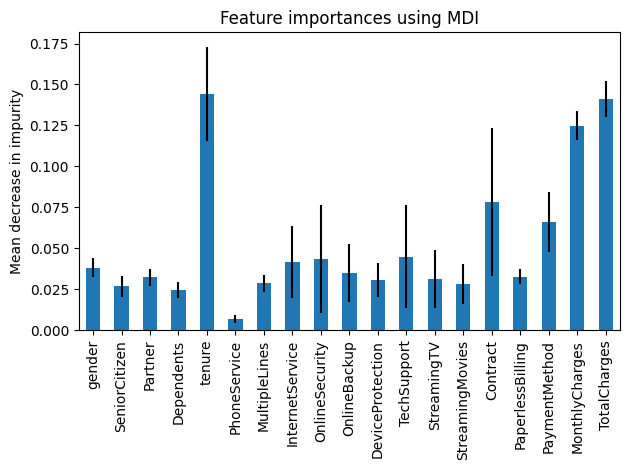

In [88]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=list(train_x.columns.values))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [94]:
forest_importances[forest_importances <0.03]

SeniorCitizen      0.026664
Dependents         0.024609
PhoneService       0.006897
MultipleLines      0.028517
StreamingMovies    0.028351
dtype: float64

# Fit/test added random columns

In [70]:
X = data.data.copy()
y = data.target.copy()

In [71]:
for i in range(10):
    X[f'fake_{i}'] = np.random.rand(len(X))

In [72]:
vectorizer = woe.WOEEncoder(cols=woe_cols)
# vectorizer = preprocessing.OneHotEncoder(handle_unknown='ignore')
label_encoder = preprocessing.LabelEncoder()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

train_y = label_encoder.fit_transform(y_train)
test_y = label_encoder.transform(y_test)

unique_classes = set(y_test)
print(f"Unique classes:{unique_classes}")

woe_train_features = vectorizer.fit_transform(X=X_train[woe_cols], y=train_y)
woe_test_features = vectorizer.transform(X=X_test[woe_cols])

original_train_df = X_train.copy()
original_train_df.update(woe_train_features)

original_test_df = X_test.copy()
original_test_df.update(woe_test_features)

train_x = original_train_df.copy()
test_x = original_test_df.copy()
model = ExtraTreesClassifier(n_estimators=16,
                           random_state=42)
model.fit(train_x, train_y)

predictions = model.predict(test_x)
predictions_scores = model.predict_proba(test_x)


acc = accuracy_score(test_y, predictions)
f1 = f1_score(test_y, predictions)
print(f'ACC: {acc}')
print(f'F1: {f1}')
roc = roc_auc_score(test_y, predictions_scores[:,1])
print(f'ROC AUC: {roc}')

Unique classes:{'No', 'Yes'}
ACC: 0.7880224041361482
F1: 0.525096525096525
ROC AUC: 0.8041860286861293


In [73]:
train_x

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,fake_0,fake_1,fake_2,fake_3,fake_4,fake_5,fake_6,fake_7,fake_8,fake_9
5767,0.031779,0,-0.368793,0.2401,65,0.013376,-0.082251,-0.460731,0.693814,0.597674,...,0.588306,0.042815,0.734048,0.198369,0.994371,0.215906,0.211557,0.480915,0.648632,0.343826
5361,0.031779,0,0.293531,-0.72085,4,0.013376,-0.082251,-1.481489,-1.481489,-1.481489,...,0.242932,0.905804,0.678866,0.551422,0.485934,0.554404,0.382878,0.480622,0.457024,0.803850
5745,0.031779,0,-0.368793,-0.72085,61,0.013376,0.120735,-1.481489,-1.481489,-1.481489,...,0.387039,0.335910,0.172727,0.116332,0.611521,0.996719,0.100972,0.761667,0.653616,0.990142
6065,-0.030656,0,0.293531,0.2401,59,0.013376,0.120735,-1.481489,-1.481489,-1.481489,...,0.531210,0.915343,0.441345,0.227434,0.659262,0.052836,0.556566,0.021326,0.574470,0.681614
229,0.031779,0,-0.368793,-0.72085,47,0.013376,0.120735,-0.460731,-0.74438,-0.234991,...,0.669002,0.276704,0.021308,0.488690,0.639296,0.245178,0.540556,0.810609,0.310008,0.089615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3778,-0.030656,0,0.293531,0.2401,3,0.013376,0.120735,-0.460731,0.693814,0.597674,...,0.030367,0.841205,0.528763,0.039101,0.763113,0.380720,0.709967,0.891400,0.714795,0.805605
5199,0.031779,0,0.293531,0.2401,51,0.013376,0.120735,0.710604,0.693814,-0.234991,...,0.593991,0.511199,0.044306,0.009238,0.377003,0.403797,0.583563,0.839649,0.824820,0.862086
5235,-0.030656,0,0.293531,0.2401,9,0.013376,0.120735,0.710604,-0.74438,0.597674,...,0.281436,0.817145,0.754072,0.997352,0.675164,0.123439,0.242438,0.314186,0.971584,0.994846
5399,0.031779,0,0.293531,0.2401,50,0.013376,-0.082251,-1.481489,-1.481489,-1.481489,...,0.501670,0.016425,0.589216,0.106016,0.420934,0.971552,0.925002,0.224435,0.129606,0.770232


### Feature importance based on mean decrease in impurity

In [74]:
import time
start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.004 seconds


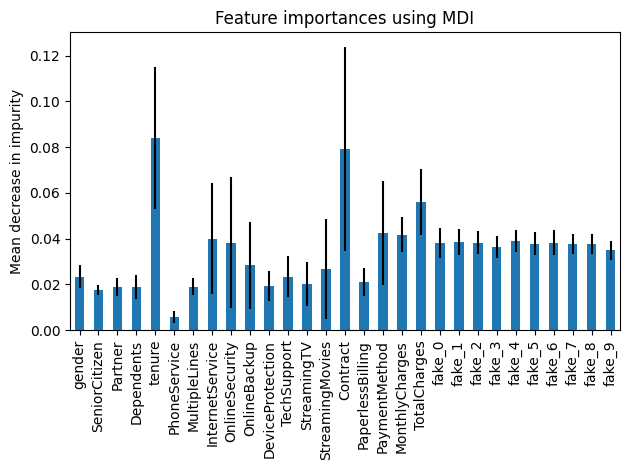

In [75]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=list(train_x.columns.values))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Boruta experiment

In [76]:
from boruta import BorutaPy

In [77]:
X = data.data.copy()
y = data.target.copy()

In [78]:
vectorizer = woe.WOEEncoder(cols=woe_cols)
# vectorizer = preprocessing.OneHotEncoder(handle_unknown='ignore')
label_encoder = preprocessing.LabelEncoder()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

train_y = label_encoder.fit_transform(y_train)
test_y = label_encoder.transform(y_test)

unique_classes = set(y_test)
print(f"Unique classes:{unique_classes}")

woe_train_features = vectorizer.fit_transform(X=X_train[woe_cols], y=train_y)
woe_test_features = vectorizer.transform(X=X_test[woe_cols])

original_train_df = X_train.copy()
original_train_df.update(woe_train_features)

original_test_df = X_test.copy()
original_test_df.update(woe_test_features)

train_x = original_train_df.copy()
test_x = original_test_df.copy()
model = ExtraTreesClassifier(class_weight='balanced', max_depth=5,n_estimators=16,
                           random_state=42)
# model.fit(train_x, train_y)
feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=0)
feat_selector.fit(train_x.values, train_y)

Unique classes:{'No', 'Yes'}
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	2
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	1
Iteration: 	10 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	1
Iteration: 	11 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	1
Iteration: 	12 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	1
Iteration: 	13 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	1
Iteration: 	14 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	1
Iteration: 	15 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	1
Iteration: 	16 / 100
Confirmed: 	17

BorutaPy(estimator=ExtraTreesClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=120,
                                        random_state=RandomState(MT19937) at 0x277C5A06B40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x277C5A06B40, verbose=2)

In [8]:
# # Check selected features
# print(feat_selector.support_)
# # Select the chosen features from our dataframe.
# selected = train_x[:, feat_selector.support_]
# print ("")
# print ("Selected Feature Matrix Shape")
# print (selected.shape)

In [79]:
X_selected = feat_selector.transform(train_x.values)

In [80]:
final_features = list()
indexes = np.where(feat_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(train_x.columns.values[x])
print(final_features)

['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


In [83]:
set(data.data.columns) - set(final_features)

{'gender'}

In [12]:
train_x[final_features]

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,personal_status,property_magnitude,age,other_payment_plans,housing
703,-0.406265,30.0,0.103985,-0.320272,2503.0,-0.162643,0.420503,0.196135,-0.026511,41.0,-0.162643,0.215348
311,1.068887,24.0,-0.197129,0.047921,5511.0,-0.162643,-0.069862,0.196135,-0.05443,25.0,-0.162643,0.215348
722,-0.788349,12.0,-0.197129,-0.450325,1228.0,-0.232912,-0.069862,-0.285246,0.504528,24.0,0.080806,0.215348
629,1.068887,9.0,-0.197129,-0.85579,3832.0,0.453543,0.420503,0.196135,0.504528,64.0,0.080806,0.215348
0,-0.788349,6.0,0.825968,0.511576,1169.0,0.453543,0.420503,0.196135,0.504528,67.0,0.080806,0.215348
...,...,...,...,...,...,...,...,...,...,...,...,...
106,1.068887,18.0,-0.916415,-0.450325,6458.0,-0.232912,0.420503,0.196135,-0.641381,39.0,-0.406265,0.215348
270,1.068887,18.0,-0.197129,-0.450325,2662.0,0.453543,0.095186,0.196135,-0.026511,32.0,0.080806,0.215348
860,1.068887,24.0,0.825968,0.548203,5804.0,0.902067,-0.069862,0.196135,0.504528,27.0,0.080806,0.215348
435,-0.406265,12.0,-0.197129,0.511576,1484.0,0.453543,-0.069862,0.006433,0.504528,25.0,0.080806,0.215348


In [13]:
model = ExtraTreesClassifier(class_weight='balanced', max_depth=5,n_estimators=16,
                           random_state=42)
model.fit(train_x[final_features], train_y)

ExtraTreesClassifier(class_weight='balanced', max_depth=5, n_estimators=16,
                     random_state=42)

In [14]:
predictions = model.predict(test_x[final_features])
predictions_scores = model.predict_proba(test_x[final_features])


acc = accuracy_score(test_y, predictions)
f1 = f1_score(test_y, predictions)
print(f'ACC: {acc}')
print(f'F1: {f1}')
roc = roc_auc_score(test_y, predictions_scores[:,1])
print(f'ROC AUC: {roc}')

ACC: 0.7363636363636363
F1: 0.7972027972027971
ROC AUC: 0.769207488434433


In [15]:
import time
start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.004 seconds


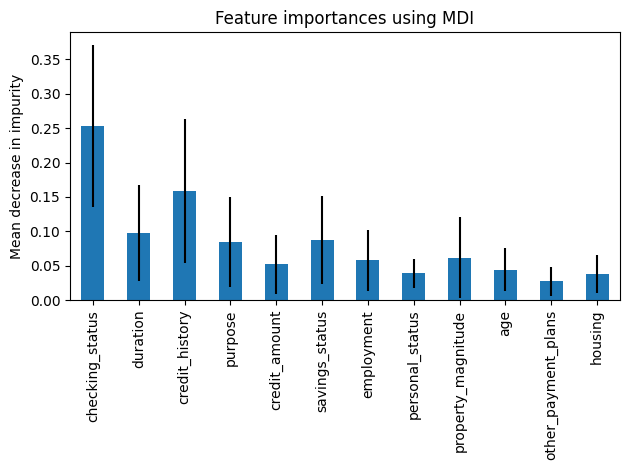

In [16]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=final_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [36]:
len(np.where(data.target == 'good')[0])

700